<a href="https://colab.research.google.com/github/eborin/SSL-course/blob/main/04_pytorch_inspecting_latent_spaces.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[View Source Code](https://github.com/eborin/SSL-course/blob/main/04_pytorch_inspecting_latent_spaces.ipynb)

# Inspecting Latent spaces

This notebook discusses how we can inspect latent spaces learned by deep learning models.

Feel free to explore my GitHub repository. 
If you find the material helpful, consider following or giving the project a ⭐ to show your support!
* <a href="https://github.com/eborin/SSL-course" target="_parent">Edson Borin's SSL course on GitHub</a>

## 1. Introduction


### 1.1 Objective

In this tutorial, we will explore how to inspect a latent spaces by using dimensionality reduction techniques such as t-SNE and UMAP.

  > Note: This is not a comprehensive guide to dimensionality reduction techniques or latent space evaluation metrics.


### 1.2 Feature extraction / Representation learning / Latent spaces

**Feature extraction** is the process of selecting and transforming relevant information from raw data while reducing dimensionality and preserving important patterns.

Traditional machine learning models require manually defined features (e.g., edge detection for images, TF-IDF for text). 
In contrast, deep learning models can learn feature representations automatically, extracting hierarchical patterns directly from data.

For example, a CNN model for image classification extracts low-level features like edges and textures in early layers, while deeper layers capture more abstract representations, such as object shapes.

**Representation learning** is a more advanced form of feature extraction where models learn meaningful, hierarchical patterns without manual intervention.

In **deep learning**, early layers capture low-level features (e.g., edges in an image, character sequences in text).
Deeper layers learn high-level representations (e.g., object structures, sentence meanings), making the learned features more useful for tasks like classification and clustering.
The extracted features are often organized in a **latent space**, where data points are structured in a way that makes them easier to process.

In classification tasks, a well-structured **latent space** clusters similar samples together, making it easier for decision-boundary classifiers (e.g., SVMs, softmax classifiers) to separate them.


### 1.3 Inspecting latent spaces

Inspecting a latent space can be done by plotting samples projected onto a chart. 
This is particularly useful for evaluating whether the latent space effectively groups similar samples (e.g., those belonging to the same class) together.

To illustrate this concept, let's consider the [Iris Dataset](https://en.wikipedia.org/wiki/Iris_flower_data_set), a widely used dataset for demonstrating machine learning concepts.

This dataset maps various features (e.g., petal length, petal width) to the species of an iris flower (setosa, versicolor, or virginica).

The chart below visualizes samples from the Iris Dataset in a latent space defined by two key features: petal width and petal length. 
Notice that the three classes (setosa, versicolor, and virginica) naturally form distinct clusters in this space.

![Iris dataset](https://raw.githubusercontent.com/eborin/SSL-course/main/images/04-iris-dataset.png)

Since the samples are well-grouped, it becomes easier to design and train a machine learning model to classify them based on these two features.

### 1.4 Dimensionality reduction techniques

A key challenge with latent spaces is that they often exist in high-dimensional spaces, making direct visualization on 2D surfaces like computer screens, whiteboards, or paper difficult.

To overcome this, **dimensionality reduction techniques** are commonly used to project the high-dimensional latent space into a 2D representation while preserving the relative distances between points. 
This means that samples that are close in the original latent space remain close in the projection, while distant samples stay far apart.

By analyzing this 2D projection, we can evaluate whether the latent space effectively clusters similar samples together, providing insights into the structure and quality of the learned representations.

Common dimensionality reduction techniques include **Principal Component Analysis (PCA)**, **Uniform Manifold Approximation and Projection (UMAP)**, and **t-Distributed Stochastic Neighbor Embedding (t-SNE)**. 
These methods project high-dimensional data into a lower-dimensional latent space, enabling qualitative evaluation of data representations. 
A well-structured latent space groups samples by class (label), ensuring that similar samples remain close together while distinct ones are well-separated.

### 1.5 What we're going to cover

In order to explore how dimensionality reduction techniques can be used to inspect latent spaces, we will:
| **Topic** | **Contents** |
| ----- | ----- |
| [**2. Train a deep learning model to classify images with handwritten digits**](#sec_2) | We will employ the CNN used in our previous tutorial and the MNIST dataset.  |
| [**3. Project the data into the latent spaces**](#sec_3) |  We will project samples from the MNIST dataset into different latents spaces.   |
| [**4. Inspecting the latent spaces with t-SNE**](#sec_4) | We will inspect the latent spaces using the t-SNE dimensionality reduction technique. |


### 1.6 Where can you get help?

Besides discussing with your colleagues and the course professor.

There's also the [PyTorch developer forums](https://discuss.pytorch.org/), a very helpful place for all things PyTorch. 

And of course, there's the [PyTorch documentation](https://pytorch.org/docs/stable/index.html) and [PyTorch developer forums](https://discuss.pytorch.org/), a very helpful place for all things PyTorch. 

## <a id='sec_2'>2. Train a deep learning model to classify images with handwritten digits</a>

Let's start by training a deep learning model to classify images with handwritten digits.

### 2.1 Importing basic modules

In [1]:
# Import PyTorch
import torch
from torch import nn

# Import numpy
import numpy as np

# Import torchvision 
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

# Import matplotlib for visualization
import matplotlib.pyplot as plt

# Check versions
# Note: your PyTorch version shouldn't be lower than 1.10.0 and torchvision version shouldn't be lower than 0.11
print(f"PyTorch version: {torch.__version__}\ntorchvision version: {torchvision.__version__}")

/usr/local/lib/python3.10/dist-packages/_distutils_hack/__init__.py:53: UserWarning: Reliance on distutils from stdlib is deprecated. Users must rely on setuptools to provide the distutils module. Avoid importing distutils or import setuptools first, and avoid setting SETUPTOOLS_USE_DISTUTILS=stdlib. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(


PyTorch version: 2.6.0+cu124
torchvision version: 0.21.0+cu124


### 2.2 Defining the model

For simplicity let's reuse the same CNN already discussed in notebook `03_pytorch_computer_vision.ipynb`.
We will add a new method called `extract_features` to encode data using only a subset of the model layers.
The goal is to use this method to project our data into a latent space of interest.

In [2]:
# Create a convolutional neural network 
class TinyVGG(nn.Module):
    """
    Model architecture based on TinyVGG from: 
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units, 
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1),# options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number 
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from? 
            # It's because each layer of our network compresses and changes the shape of our input data.
            nn.Linear(in_features=hidden_units*7*7, 
                      out_features=output_shape)
        )
        # Flatten layer to reorganize the extracted features into a vector.
        self.flatten_features = nn.Flatten()
    
    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.classifier(x)
        return x

    #vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv
    # nblocks parameter can be used to retrieve the data representation on specific latent spaces.
    # In case nblocks:
    #  = 1: Only the first block (block_1) is applyed to the input sample;
    #  = 2: Both block_1 and block_2 are applyed to the input sample; and
    #  = 3 or more: The whole model is applyed.k
    def extract_features(self, x: torch.Tensor, nblocks:int = 2):
        if (nblocks >=1):
            x = self.block_1(x)
        if (nblocks >=2):
            x = self.block_2(x)
        if (nblocks >=3):
            x = self.classifier(x)
        return self.flatten_features(x)
    #^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Notice the new method called `extract_features`. 
By default, it extracts feature by applying the layers contained in `block_1` and `block_2`. 
However, if needed, the user may select the set of layers to  be applyied by changing the `nblocks` parameter.

### 2.3 Creating the training loop

Again, we will reuse the same training loop discussed in notebook `03_pytorch_computer_vision.ipynb`.

In [3]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    """Calculates accuracy between truth labels and predictions.

    Args:
        y_true (torch.Tensor): Truth labels for predictions.
        y_pred (torch.Tensor): Predictions to be compared to predictions.

    Returns:
        [torch.float]: Accuracy value between y_true and y_pred, e.g. 78.45
    """
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [4]:
# Import tqdm for progress bar
from tqdm.auto import tqdm
# Import the default_timer from timeit to time the training process
from timeit import default_timer as timer 

def train_model(model, train_dataloader, val_dataloader, nepochs=3):
    # Set the seed
    torch.manual_seed(42)

    # Setup the loss function. This is also called "criterion"/"cost function" in some places
    # The cross entropy loss is more adequate for classification problems.
    loss_fn = nn.CrossEntropyLoss() 

    # Setup the optimizer
    optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1)

    # Lists to store the training losses, validation losses, and validation accuracies over epochs
    training_losses, val_losses, val_accs = [], [], []

    # Register the start time
    train_start_time = timer()

    # For each epoch, do
    for epoch in range(nepochs):

        print(f"----------------------\nEpoch: {epoch+1} / {nepochs}")

        ### Variable to register the accumulated training loss
        train_loss = 0.0

        # For each batch in the training dataloader, do:
        for _, (X, y) in tqdm(enumerate(train_dataloader), total=len(train_dataloader), unit=" batches", desc="Training  "):

            model.train() 
            # 1. Forward pass
            y_pred = model(X)
            # 2. Calculate loss (per batch)
            loss = loss_fn(y_pred, y)
            train_loss += loss.cpu().detach() # Accumulates the training losses
            # 3. Optimizer zero grad
            optimizer.zero_grad()
            # 4. Loss backward
            loss.backward()
            # 5. Optimizer step
            optimizer.step()
            # Print out how many samples have been seen
            # if batch % 400 == 0: print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")

        # Divide total train loss by length of train dataloader (average loss per batch per epoch)
        avg_train_loss = train_loss / len(train_dataloader)
        training_losses.append(avg_train_loss)
        ### Validating
        # Setup variables for accumulatively adding up loss and accuracy 
        val_loss, val_acc = 0, 0 
        model.eval()
        with torch.inference_mode():
            # For each batch in the validation dataloader, do:
            for _, (X, y) in tqdm(enumerate(val_dataloader), total=len(val_dataloader), unit=" batches", desc="Validation"):
                # 1. Forward pass
                val_pred = model(X)
                # 2. Calculate loss (accumulatively)
                loss = loss_fn(val_pred, y) # accumulatively add up the loss per epoch
                val_loss += loss.cpu().detach()
                # 3. Calculate accuracy (preds need to be same as y_true)
                val_acc += accuracy_fn(y_true=y, y_pred=val_pred.argmax(dim=1))
            
            # Calculations on val metrics need to happen inside torch.inference_mode()
            # Divide total val loss by length of val dataloader (per batch)
            avg_val_loss = val_loss / len(val_dataloader)
            val_losses.append(avg_val_loss)

            # Divide total accuracy by length of val dataloader (per batch)
            val_acc /= len(val_dataloader)
            val_accs.append(val_acc)

        ## Print out what's happening
        print(f"Train loss: {avg_train_loss:.5f} | Validation loss: {avg_val_loss:.5f}, Validation accuracy: {val_acc:.2f}%\n")

    # Register the stop time
    train_stop_time = timer()
    training_elapsed_time = train_stop_time - train_start_time

    # Return the elapsed training time, the training losses, 
    # the validation losses, and the validation accuracies
    return training_elapsed_time, training_losses, val_losses, val_accs

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 2.4 Getting the MNIST handwritten digits dataset

Let's download and partition the training data into train and validation subsets.

First, let's download the dataset.

In [5]:
# Setup training data
train_dataset = datasets.MNIST(
    root="data", # where to download data to?
    train=True, # get training data
    download=True, # download data if it doesn't exist on disk
    transform=ToTensor(), # images come as PIL format, we want to turn into Torch tensors
    target_transform=None # you can transform labels as well
)

Now, let's perform a random split on the data. 

The following code splits the data into three sets: training, validation, and discarded.
The discarded set consists of samples that will not be used in our experiments.
Increasing its size reduces the training and validation set sizes, helping to decrease the time required for model training and other operations, such as dimensionality reduction.
For this experiment, we will discard 80% of the data.

In [6]:
from torch.utils.data import random_split

discard_ratio = 0.8 # 80% of the data will be discarded
train_val_ratio = 0.8 # 80% of the remaining data will be dedicated to the training set

total_size = len(train_dataset)
discard_size = int(discard_ratio * total_size)
train_size = int(train_val_ratio * (total_size-discard_size))
val_size = total_size - train_size - discard_size

# Split the dataset
torch.manual_seed(42)
train_data, val_data, discard_data = random_split(train_dataset, [train_size, val_size, discard_size])

print("len(train subset):", len(train_data))
print("len(val subset):", len(val_data))
print("len(discard subset):", len(discard_data))

len(train subset): 9600
len(val subset): 2400
len(discard subset): 48000


Let's inspect a sample

In [7]:
sample = 1
image, label = train_data[sample]
print("Sample shape:", image.shape)
print("Sample label:", label)

Sample shape: torch.Size([1, 28, 28])
Sample label: 7


Ok, it is a sample with shape 1x28x28 (1 channel, width=28, height=28) and it belongs to class 7 (label=7).
Lets drop the channel dimension (squeeze()) and plot the image using matplotlib.

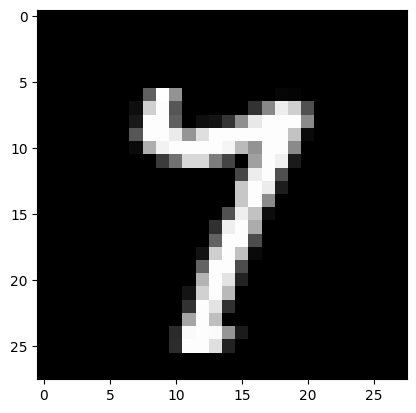

In [8]:
fig = plt.figure
plt.imshow(image.squeeze(), cmap='gray')
plt.show()

Nice! It looks like a handwritten version of the number seven.

Now, lets create the dataloaders for our training and validation sets.

In [9]:
from torch.utils.data import DataLoader

# Setup the batch size hyperparameter
BATCH_SIZE = 32

# Turn datasets into iterables (batches)
train_dataloader = DataLoader(train_data, # dataset to turn into iterable
    batch_size=BATCH_SIZE, # how many samples per batch? 
    shuffle=True # shuffle data every epoch?
)

val_dataloader = DataLoader(val_data,
    batch_size=BATCH_SIZE,
    shuffle=False # don't necessarily have to shuffle the validation data
)

# Let's check out what we've created
print(f"Dataloaders: {train_dataloader, val_dataloader}") 
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE} samples")
print(f"Length of validation dataloader: {len(val_dataloader)} batches of {BATCH_SIZE} samples")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x7b2838157d00>, <torch.utils.data.dataloader.DataLoader object at 0x7b2838157310>)
Length of train dataloader: 300 batches of 32 samples
Length of validation dataloader: 75 batches of 32 samples


### 2.5 Training the model

Now that we have the model, the code to train the model, and the dataset, let's instantiate and train the model.

In [10]:
number_of_epochs = 5

# Instantiate the model
torch.manual_seed(42)
trained_model = TinyVGG(input_shape=1, hidden_units=10, output_shape=10)

# Train the model
training_elapsed_time, training_losses, val_losses, val_accs = train_model(trained_model, train_dataloader, val_dataloader, nepochs=number_of_epochs)

print(f"Trained model on {str(next(trained_model.parameters()).device)} for {len(training_losses)} epochs in {training_elapsed_time:.3f} seconds")

----------------------
Epoch: 1 / 5


Validation: 100%|██████████| 75/75 [00:00<00:00, 326.35 batches/s]


Train loss: 1.02030 | Validation loss: 0.21830, Validation accuracy: 92.58%

----------------------
Epoch: 2 / 5


Validation: 100%|██████████| 75/75 [00:00<00:00, 353.54 batches/s]


Train loss: 0.17285 | Validation loss: 0.10438, Validation accuracy: 96.96%

----------------------
Epoch: 3 / 5


Validation: 100%|██████████| 75/75 [00:00<00:00, 320.20 batches/s]


Train loss: 0.11274 | Validation loss: 0.09960, Validation accuracy: 96.92%

----------------------
Epoch: 4 / 5


Validation: 100%|██████████| 75/75 [00:00<00:00, 336.18 batches/s]


Train loss: 0.08963 | Validation loss: 0.08564, Validation accuracy: 97.50%

----------------------
Epoch: 5 / 5


Validation: 100%|██████████| 75/75 [00:00<00:00, 307.98 batches/s]

Train loss: 0.06962 | Validation loss: 0.09150, Validation accuracy: 97.58%

Trained model on cpu for 5 epochs in 10.191 seconds


## <a id='sec_3'>3. Projecting the data into the latent spaces</a>

We have a trained model. Now, let's project the samples from the validation set into the latent spaces.

We will compare three latent spaces: 
* a) the original one, i.e., defined by the set of pixel values in the images. To do so, it suffices to flatten the pixel values of the original data into a vector.
* b) the untrained latent space, i.e., the space defined by the features produced by the set of untrained layers comprised by `block_1` and `block_2`. To do so, we will use the `extract_features` method on an untrained model.
* c) the trained latent space, i.e., the space defined by the features produced by the set of trained layers comprised by `block_1` and `block_2`. Here, we will use the `extract_features` method on the trained model.

We already have the trained model. Let's create an untrained model.

In [11]:
torch.manual_seed(42)
untrained_model = TinyVGG(input_shape=1, hidden_units=10, output_shape=10)

### 3.1 Projecting the data into the original latent space (a)

In this case, there is no need to use special functions to extract features. 
However, we still need to reorganize the data into a vector to facilitate the inspection -- notice that the images are comprised by 1x28x28 tensors. 
We will use the `nn.Flatten()` layer to convert the 1x28x28 tensors into vectors with 784 values.

In [12]:
features_list = []
labels_list = []

def flatten_features(dataloader):
    # Create a flatten layer to reorganize the data into an array with 784 values
    flatten_model = nn.Flatten()
    flatten_model.eval()
    features_list = []
    labels_list = []
    with torch.no_grad():
        for batch in dataloader:
            images = batch[0]  # Extracting the batch images
            labels = batch[1]  # Extracting the batch labels
            features = flatten_model(images) # Get embeddings from the model
            features_list.append(features.cpu().numpy())
            labels_list.append(labels.numpy())
    return np.concatenate(features_list), np.concatenate(labels_list)

# Create a dictionary to group the features and labels for the original latent space (ls)
ls_original = { }
ls_original["features"], ls_original["labels"] = flatten_features(val_dataloader)
print("original latent space features shape:", ls_original["features"].shape)
print("original latent space labels shape:", ls_original["labels"].shape)

original latent space features shape: (2400, 784)
original latent space labels shape: (2400,)


Ok, the validation data was projected into the original latent space. 
Notice that each sample is represented by a vector with 784 values.

Now, let's extract the features using the untrained and trained models.

### 3.2 Projecting the data into the latent spaces (b) and (c)

The following function extracts features from data in a given dataloader using the `extract_features` method of a machine learning model.

In [13]:
import numpy as np

def extract_features(model, dataloader):
    model.eval()
    features_list = []
    labels_list = []
    with torch.no_grad():
        # For each batch
        for batch in dataloader:
            images = batch[0]  # Extracting the batch images
            labels = batch[1]  # Extracting the batch labels
            features = model.extract_features(images) # Get embeddings from the model
            features_list.append(features.cpu().numpy())
            labels_list.append(labels.numpy())

    return np.concatenate(features_list), np.concatenate(labels_list)

Great, now let's extract the features using the trained and the untrained model.

In [14]:
ls_trained = {}
ls_trained["features"], ls_trained["labels"] = extract_features(trained_model, val_dataloader)
print("trained latent space features shape:", ls_trained["features"].shape)
print("trained latent space labels shape:", ls_trained["labels"].shape)

ls_untrained = {}
ls_untrained["features"], ls_untrained["labels"] = extract_features(untrained_model, val_dataloader)
print("untrained latent space features shape:", ls_untrained["features"].shape)
print("untrained latent space labels shape:", ls_untrained["labels"].shape)

trained latent space features shape: (2400, 490)
trained latent space labels shape: (2400,)
untrained latent space features shape: (2400, 490)
untrained latent space labels shape: (2400,)


Observe that the data dimensionality (490) differs from the original (784).
This occurs because the initial layers of the TinyVGG network project the input data (784 values) into a lower-dimensional latent space.

## <a id='sec_4'>4. Visualizing high-dimensional data with t-SNE</a>


Now it is time to use t-SNE to project the data from the three latent spaces into 2D-spaces and plot them to inspect how the data is organized (grouped) in the latent space.

In this exercise, we will use the `TSNE` class from `sklearn`.

First, lets import the TSNE class and instantiate the tsne object. 
We will reduce the dimensionality to two, hence, `n_components=2`. 


In [15]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)

Now, for each latent space (ls), lets project the data into a 2D-space using t-SNE.

In [16]:
latent_spaces = [ ("Original space (a)", ls_original), 
                  ("Untrained TinyVGG (b)", ls_untrained), 
                  ("Trained TinyVGG (c)", ls_trained) ]

for ls_name, ls in latent_spaces:
    print(f"Projecting features with t-SNE: {ls_name}")
    ls["tsne-features"] = tsne.fit_transform(ls["features"])

Projecting features with t-SNE: Original space (a)
Projecting features with t-SNE: Untrained TinyVGG (b)
Projecting features with t-SNE: Trained TinyVGG (c)


Finally, let's plot the samples in the latent spaces. 

The following function visualizes two-dimensional feature representations of data points, using color to indicate different class labels. 
It helps in understanding how well a model's learned representation separates different classes.

In [17]:
# Function to plot data
def plot_samples(features, labels, title):
    fig, ax = plt.subplots()
    scatter = ax.scatter(features[:, 0], features[:, 1], c=labels, cmap='jet')
    legend1 = ax.legend(*scatter.legend_elements(), loc="upper left", title="Class")
    ax.add_artist(legend1)
    ax.set_title(title)
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
    ax.grid(True)
    plt.show()

Now, lets invoke the `plot_samples` function to plot the validation samples on each one of the latent spaces.

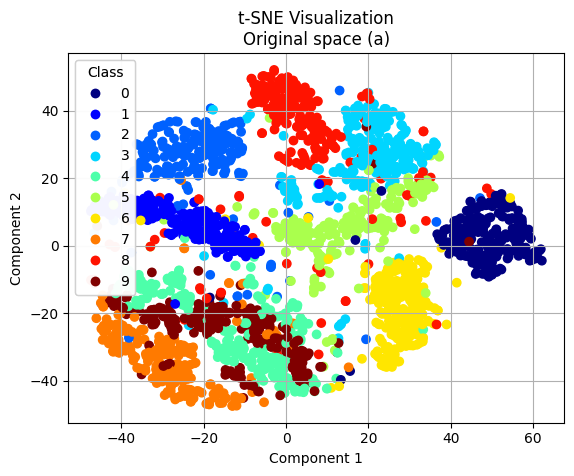

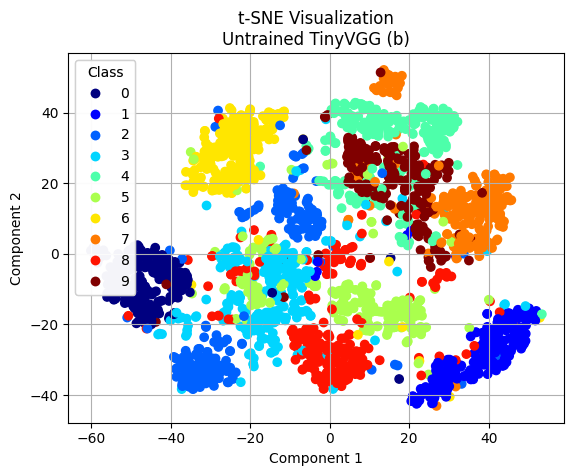

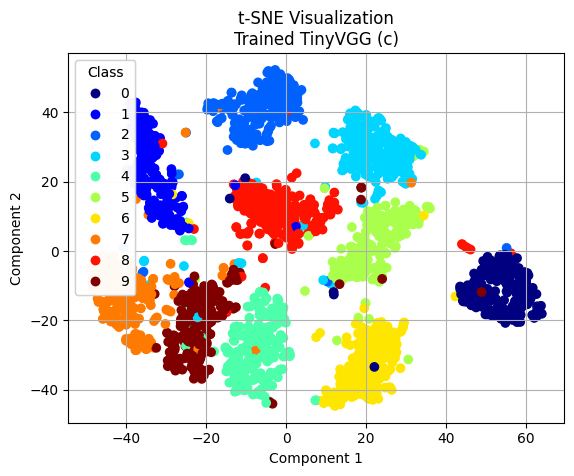

In [18]:
# Plot the samples using the t-SNE features
for ls_name, ls in latent_spaces:
    plot_samples(features=ls["tsne-features"],
                 labels=ls["labels"],
                 title=f't-SNE Visualization\n{ls_name}')

Observe that the samples are more distinctly clustered by class in the trained TinyVGG latent space (c).

In contrast, the original and untrained TinyVGG latent spaces exhibit greater overlap among samples from classes 4, 7, and 9, leading to increased confusion.

Consequently, classifiers are likely to perform better when using the representation learned by the trained model.

## Exercises

While there is no designated exercise for this tutorial, the following activities can provide valuable insights into factors that influence model performance:
* Train the model for more epochs (e.g., for 30 epochs) and verify if the distribution of the data in the latent space changes.
* Modify the code in Section 4 to use the UMAP dimensionality reduction technique instead of t-SNE.
* Evaluate the performance of classic machine learning models (e.g., decision trees) on the MNIST data projected into the three latent spaces explored in this notebook.
* Train the TinyVGG model on a different dataset (e.g., FashionMNIST) and assess whether the learned representation generalizes well to the MNIST dataset.
